# Trabalho Final

Alguns pontos essenciais da apresentação:

1. Apresentação da análise do Problema
2. Apresentação da análise e tratamento dos dados
3. Justificativa do uso de técnicas de IA para Resolução do problema
4. Justificativa da escolha do ambiente de desenvolvimento, teste e uso
5. Apresentação da metodologia da solução com uso de IA
6. Aplicação das técnicas de Inteligência Artificial no seu problema
7. Estratégias para obtenção de resultados melhores para solução do prooblema
8. Análise dos resultados            
9. Conclusões
10. Trabalhos futuros

Alguns critérios de Avaliações:

a) O problema ou dados foram analisados pensando-se na solução com uso de IA?
b) A solução apresentada tem fundamento? Justifica-se com os conceitos da IA?
c) A ambiente para desenvolvimento da solução faz uso das ferramentas atuais? Considera soluções atuais apresentadas pela comunidade científica e de desenvolvimento?
d) A solução apresentada buscou aproveitar, ao máximo, a técnica de IA? Houve preocupação em ajustar parâmetros para solução?
e) A análise foi feita de forma adequada?
f) Pensou em como seria o uso efetivo da sua solução?


## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
np.set_printoptions(threshold=np.inf)

from PIL import Image, ImageFilter

import os, shutil
from pathlib import Path
import random

import tensorflow as tf 
from tensorflow import keras

SEED = 42
np.random.seed(SEED)

BASE_PATH = Path.cwd().parent
PRE_PATH = BASE_PATH / 'data' / 'pre'

2022-12-13 13:39:29.920975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 13:39:30.708915: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 13:39:31.816337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 13:39:31.816390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Conexão Google Drive

In [2]:
# # Mount Google Drive 
# from google.colab import drive
# drive.mount('/content/drive')

## Carregamento das imagens

In [3]:
grid_map = {
    '64_32':64,
    '64_48':64,
    '128_64':128,
    '256_128':256
}

spatial_res_map = {
    '2m':2,
    '1m':1,
    '05m': 0.5
}

In [4]:
def get_images(imgs_dir, imgs_names, img_size, crop_size):
    """
    Inputs:
        imgs_dir: path to the images directory
        imgs_names: list of images names
        img_size: size of the images
        crop_size: size of the crop
    Outputs:
        imgs_resized: list of images resized and cropped
    """
    img_shape = (img_size, img_size)
    crop_shape = (crop_size, crop_size, img_size-crop_size, img_size-crop_size)
    imgs = [Image.open(imgs_dir / img_name) for img_name in imgs_names]
    imgs_resized = [img.resize(img_shape).crop(crop_shape) for img in imgs]

    return imgs_resized

In [5]:
def imgs_to_array(imgs):
    # print(imgs[:10])
    img_array = np.stack([np.asarray(img) for img in imgs], axis=0)
    # print(img_array.shape)
    return img_array

In [6]:
def get_labels(spatial_res, grid, dataset, threshold=0.05, samples=None, positive_only=False, balance_classes=False):
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    crop_size = 1
    imgs_dir = Path(PRE_PATH, 'Labels', spatial_res, grid, dataset)
    imgs_names = [name for name in os.listdir(imgs_dir) if name[-3:] == 'jpg']
    imgs = get_images(imgs_dir, imgs_names, img_size, crop_size)
    imgs_array = imgs_to_array(imgs)
    labels = imgs_array.sum(axis=1).sum(axis=1) / (img_size^2) > threshold
    labels = labels.astype(int)
    
    if positive_only:
        pos_idx = np.where(labels >= 1)[0]
        imgs_names = [imgs_names[idx] for idx in pos_idx]
        labels = labels[pos_idx]
    
    if balance_classes:
        pos_idx = np.where(labels >= 1)[0]
        neg_idx = np.where(labels == 0)[0]
        pos_names = [imgs_names[idx] for idx in pos_idx]
        samples_neg = np.random.choice(np.arange(len(neg_idx)), size=len(pos_idx), replace=False)
        neg_names = [imgs_names[idx] for idx in samples_neg]
        imgs_names = pos_names + neg_names
        labels = np.concatenate([labels[pos_idx], labels[samples_neg]])

    if samples is not None:
        samples_idx = np.random.choice(np.arange(len(labels)), samples, replace=False)
        imgs_names = [imgs_names[idx] for idx in samples_idx]
        labels = labels[samples_idx]
        
    return imgs_names, labels

In [7]:
def plot_images(spatial_res, grid, dataset, positive=True, samples=5, sources=None):
    names, labels = get_labels(spatial_res, grid, dataset, 0.05, samples, positive)
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    if sources == None:
        sources = ['CBERS_234', 'CBERS_321', 'CBERS_432', 'Labels', 'Google']

    src_imgs = []
    for source in sources:
        if source == 'Google':
            imgs = get_images(Path(PRE_PATH, source, '03m', grid, dataset), names, int(grid_map[grid] / 0.3), 2)
        else:
            imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, dataset), names, img_size, 2)

        src_imgs.append(imgs)

    fig, axs = plt.subplots(len(src_imgs), samples, figsize=(12, samples*2.5))
    for i, imgs in zip(range(len(src_imgs)), src_imgs):
        for j in range(samples):
            axs[i, j].imshow(imgs[j])
            axs[i, j].title.set_text(names[j])
    plt.tight_layout()
    plt.show()
    return names, labels


In [8]:
df = pd.DataFrame(columns=['spatial_res', 'grid', 'dataset', 'imgs', 'pos', '%pos'])

for spatial_res in ['2m']:
    for grid in ['64_48']:
        for dataset in ['Train', 'Test']:
            _, labels = get_labels(spatial_res, grid, dataset)
            df = pd.concat([df, 
                            pd.DataFrame({'spatial_res':[spatial_res],
                                          'grid':[grid],
                                          'dataset':[dataset],
                                          'imgs':[labels.shape[0]],
                                          'pos':[labels.sum()]},)], ignore_index=True)

df['%pos'] = df.pos / df.imgs    
df.head(100)

,spatial_res,grid,dataset,imgs,pos,%pos
0,2m,64_48,Train,2611,216,0.082727
1,2m,64_48,Test,556,91,0.163669


## Inspeção visual

### Dataset Treino - Amostras Positivas

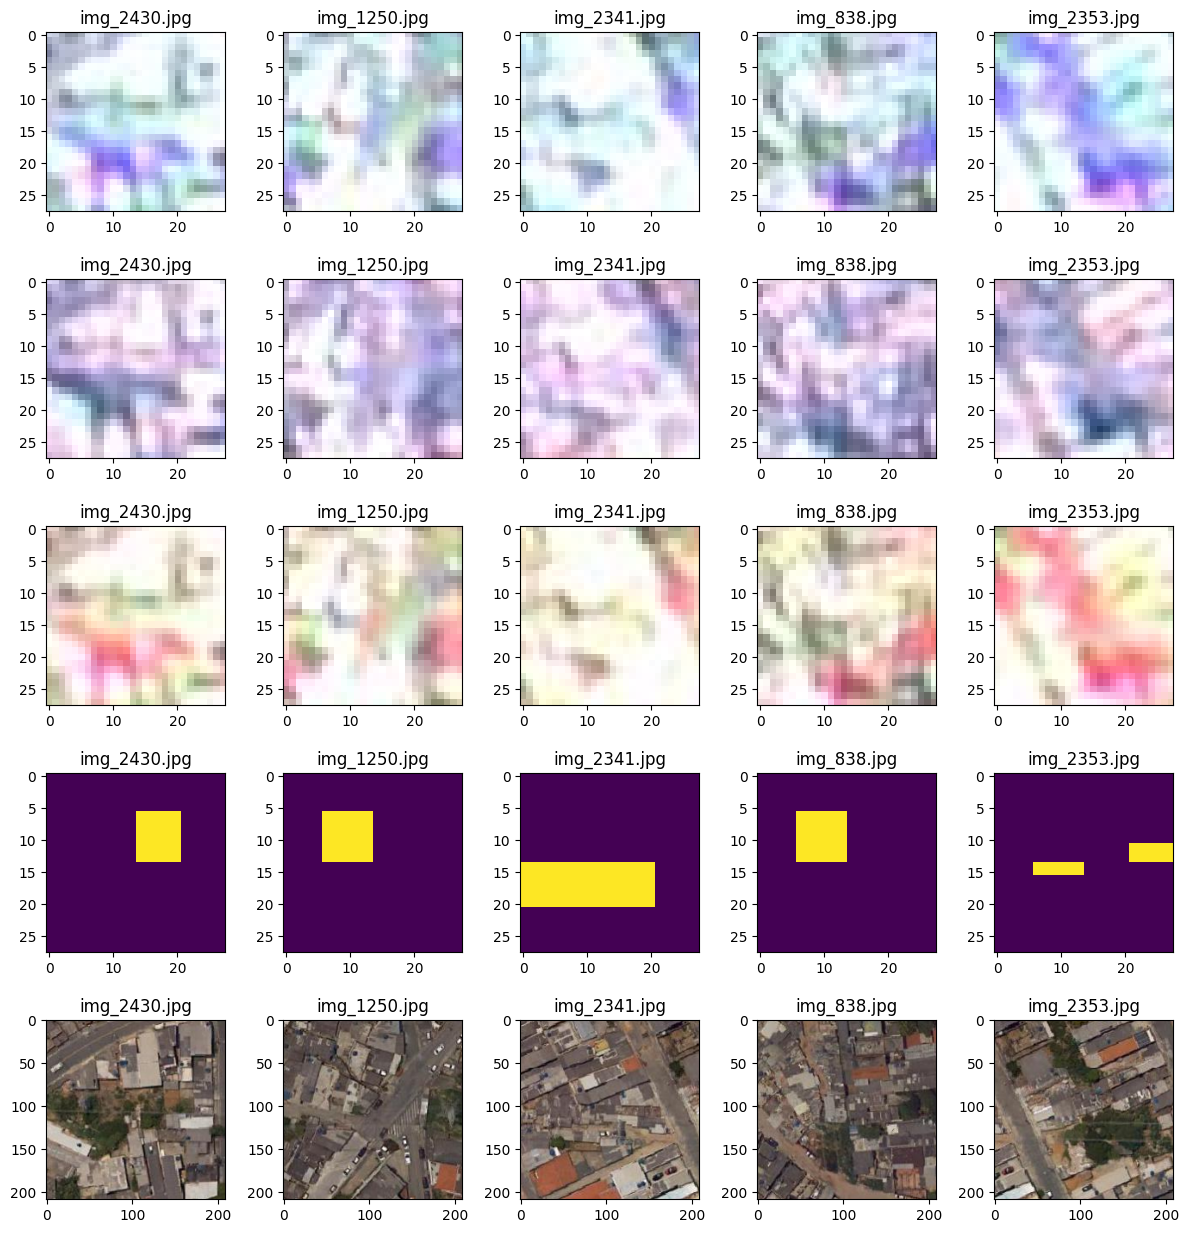

In [9]:
names, labels = plot_images('2m', '64_48', 'Train')

### Dataset Treino - Amostras Negativas

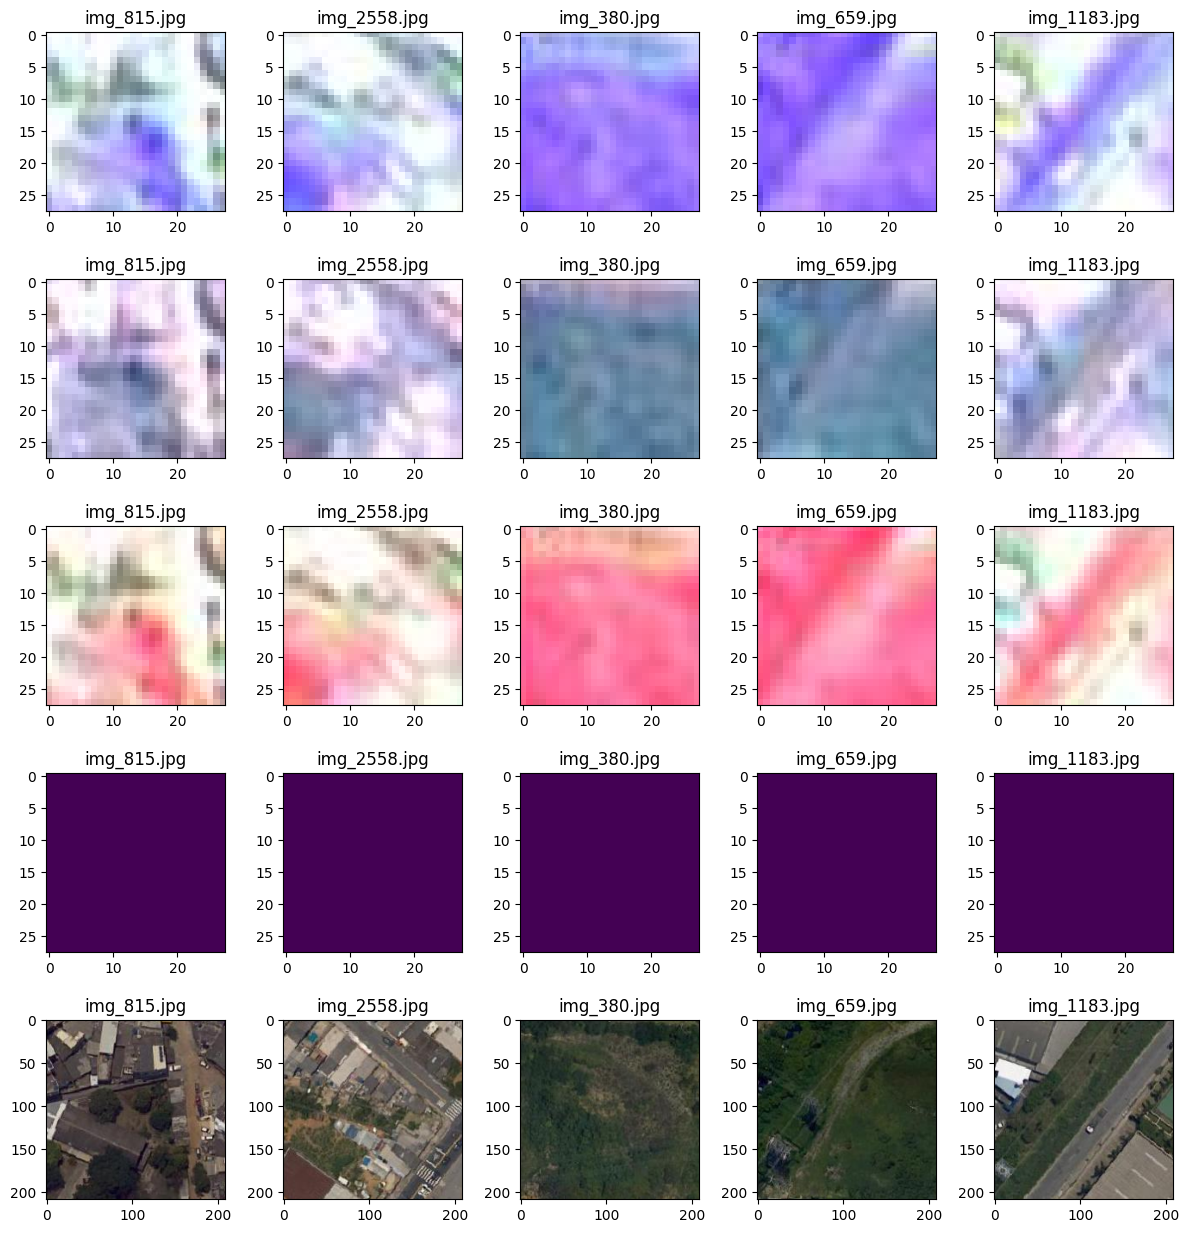

In [10]:
names, labels = plot_images('2m', '64_48', 'Train', False, 5)

### Dataset Teste - Amostras Positivas

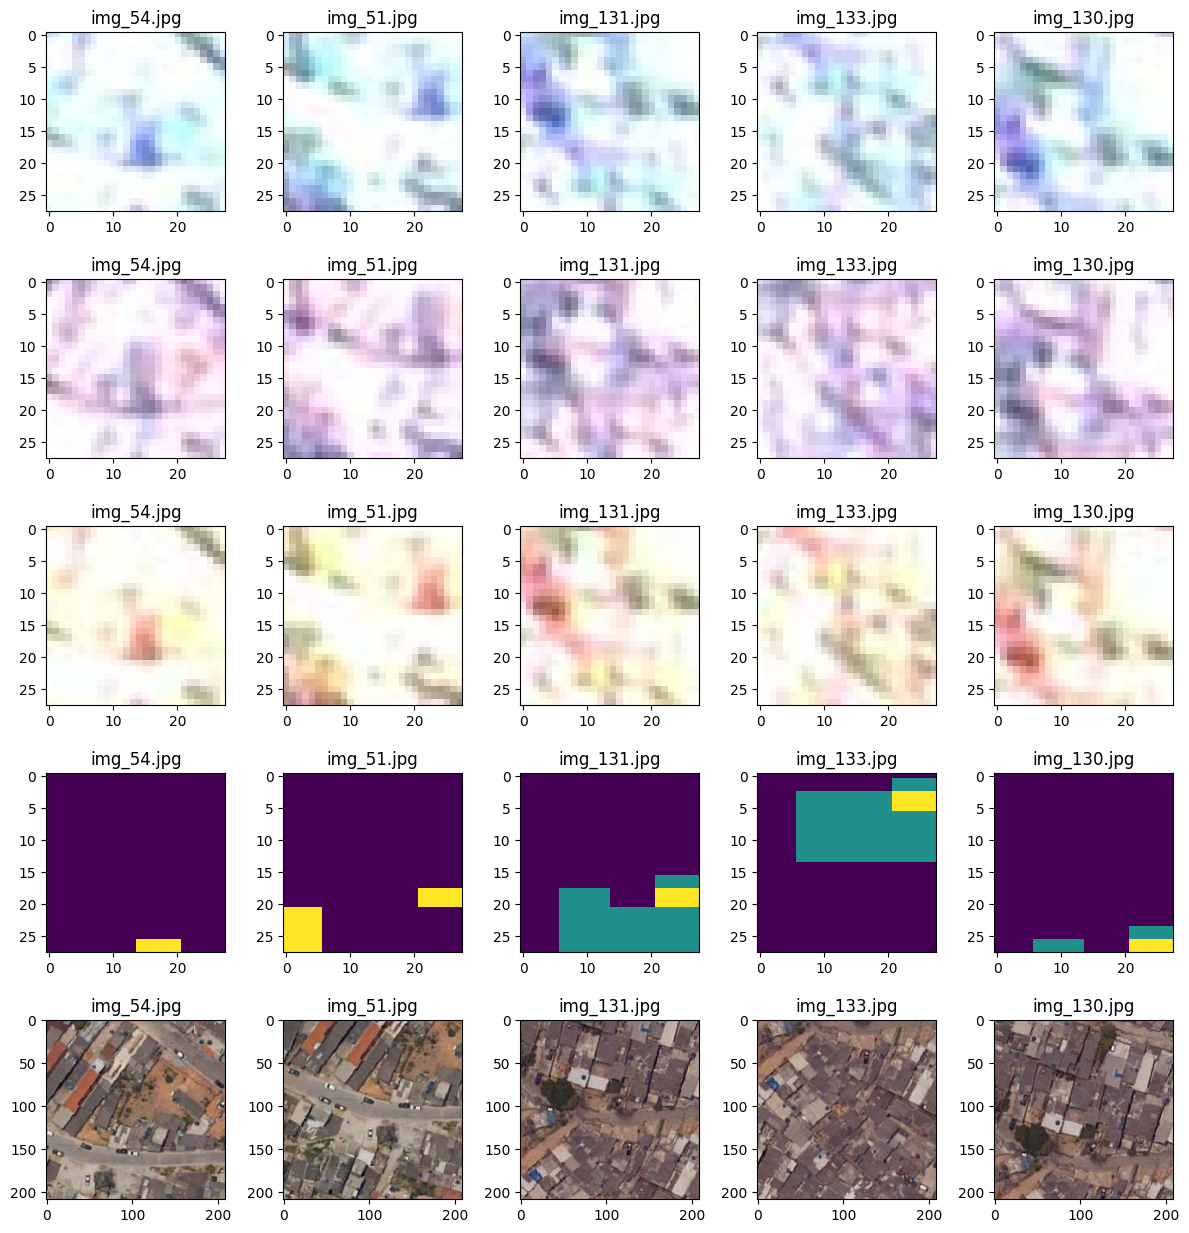

In [11]:
names, labels = plot_images('2m', '64_48', 'Test')

### Dataset Teste - Amostras Negativas

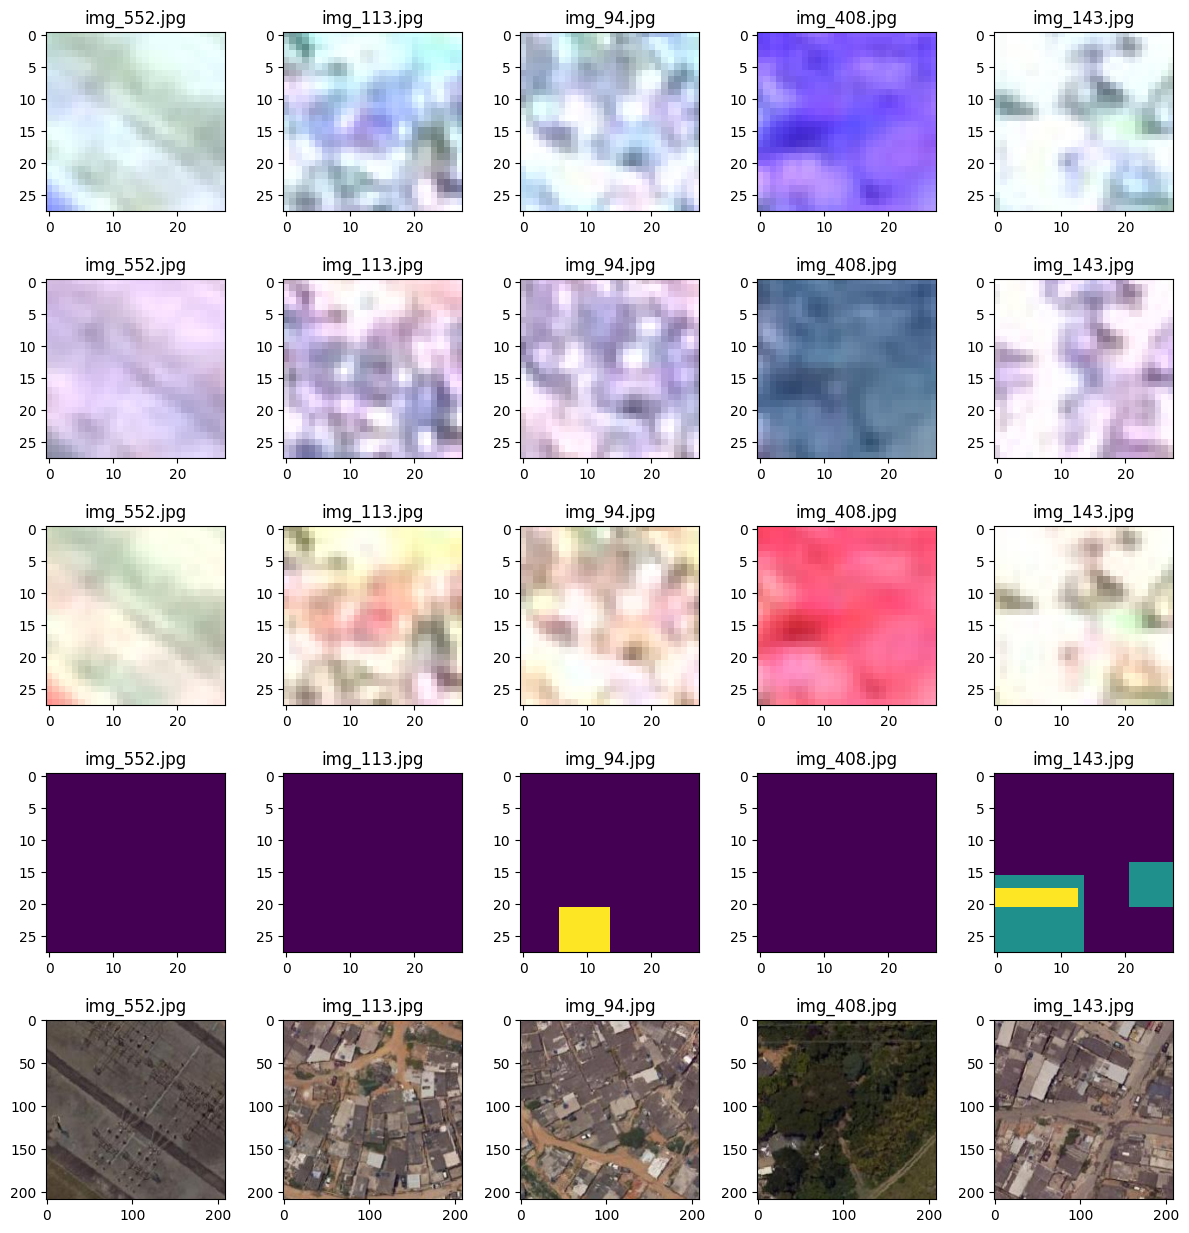

In [12]:
names, labels = plot_images('2m', '64_48', 'Test', False, 5)

## Criando a Rede Neural Convolucional

In [21]:
def build_model(size):
    inputs = keras.Input(shape=(size, size, 3))
    x = keras.layers.Rescaling(1./255)(inputs)
    x = keras.layers.Conv2D(filters=2, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)
    x = keras.layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)
    x = keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(1, kernel_regularizer=keras.l2(0.001), activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

## Preparando Dados de Treino e Teste

In [22]:
def make_train_test(source, spatial_res, grid, only_train=False):
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    train_names, y_train = get_labels(spatial_res, grid, 'Train', 0.05, None, False, True)
    train_imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, 'Train'), train_names, img_size, 1)
    X_train = imgs_to_array(train_imgs)

    if only_train == False:
        test_names, y_test = get_labels(spatial_res, grid, 'Test', 0.05, None, False, True)
        test_imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, 'Test'), test_names, img_size, 1)
        X_test = imgs_to_array(test_imgs)
    else:
        y_test = None
        X_test = None
    
    return X_train, y_train, X_test, y_test

## Treinando o modelo com validação cruzada

In [23]:
from sklearn.model_selection import StratifiedKFold

def train_model_kfold(source, spatial_res, grid, n_splits=5, num_epochs=100, batch_size=16):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    X_train, y_train, _, _ = make_train_test(source, spatial_res, grid, True)
    
    img_size = grid_map[grid] / spatial_res_map[spatial_res]
    img_size = int(img_size) - 2

    all_loss, all_val_loss, all_acc, all_val_acc = [], [], [], []
    fold = 0

    for train_idx, val_idx in kfold.split(X_train, y_train):
        
        X_train_fold = X_train[train_idx].copy()
        y_train_fold = y_train[train_idx].copy()
        
        X_val_fold = X_train[val_idx].copy()
        y_val_fold = y_train[val_idx].copy()
        
        model = build_model(img_size)
        # model.summary()
        
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=num_epochs, batch_size=batch_size, verbose=0)
        
        # loss
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        all_loss.append(loss)
        all_val_loss.append(val_loss)

        # accuracy
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        all_acc.append(acc)
        all_val_acc.append(val_acc)

        print('Fold {}: Train Loss {:0.3f} | Train Acc {:0.3f}'.format(fold,
                                                                    loss[-1],
                                                                    acc[-1]))
        print('Fold {}: Val   Loss {:0.3f} | Val   Acc {:0.3f}'.format(fold,
                                                                    val_loss[-1],
                                                                    val_acc[-1]))
        fold += 1
        
    results = {
        'all_loss': all_loss,
        'all_val_loss': all_val_loss,
        'all_acc': all_acc,
        'all_val_acc': all_val_acc
    }
    return results

In [24]:
def plot_results(results):
    all_loss = results['all_loss']
    all_val_loss = results['all_val_loss']
    all_acc = results['all_acc']
    all_val_acc = results['all_val_acc']

    num_epochs = len(all_loss[0])

    average_loss_history = [
        np.mean([x[i] for x in all_loss]) for i in range(num_epochs)]

    average_val_loss_history = [
        np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]

    average_acc_history = [
        np.mean([x[i] for x in all_acc]) for i in range(num_epochs)]

    average_val_acc_history = [
        np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, average_loss_history, "bo", label="Training loss")
    plt.plot(epochs, average_val_loss_history, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print()
    plt.plot(epochs, average_acc_history, "bo", label="Training accuracy")
    plt.plot(epochs, average_val_acc_history, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score

def avalia_modelo(y, p, title):

    TN, FP, FN, TP = confusion_matrix(y, p).ravel()
    f1 = f1_score(y, p)
    f2 = fbeta_score(y, p, beta=2)
    MCC = matthews_corrcoef(y, p)
    acc = accuracy_score(y, p)
    print()
    print('#-----------------------------< ' + title + ' >-----------------------------#')
    print("n = {}\t\t\tPredicted Positive \tPredicted Negative".format(p.shape[0]))
    print("Actually Positive\t\t{} \t\t\t{}".format(TP, FN))
    print("Actually Negative\t\t{} \t\t\t{}".format(FP, TN))
    print()
    print('Acc', acc)
    print("f1", f1)
    print("f2", f2)
    print("MCC", MCC)
#     print("#-------------------------------------------------------------------------#")

    scores = {
        "TN":TN,
        "FP":FP,
        "FN":FN,
        "TP":TP,
        "f1":f1,
        "f2":f2,
        "MCC":MCC
    }
  
    return scores

In [26]:
from sklearn.metrics import classification_report

def evaluate_model(source, spatial_res, grid, num_epochs=100, batch_size=16):
    X_train, y_train, X_test, y_test = make_train_test(source, spatial_res, grid, False)
    img_size = grid_map[grid] / spatial_res_map[spatial_res]
    img_size = int(img_size) - 2

    model = build_model(img_size)
    history = model.fit(X_train, y_train,
                        epochs=num_epochs, batch_size=batch_size, verbose=0)

    train_preds = np.round(model.predict(X_train), 0)
    test_preds = np.round(model.predict(X_test), 0)

    avalia_modelo(y_train, train_preds, 'Training')
    avalia_modelo(y_test, test_preds, 'Test')
    

In [27]:
def complete_experiment(source, spatial_res, grid, num_epochs=100, batch_size=16):
    results = train_model_kfold(source, spatial_res, grid, 5, num_epochs, batch_size)
    plot_results(results)
    evaluate_model(source, spatial_res, grid, num_epochs, batch_size)

## Experimentos - CBERS_234

In [28]:
complete_experiment('CBERS_234', '2m', '64_48')

2022-12-13 13:40:59.888330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 13:41:00.029965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 13:41:00.030117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 13:41:00.031260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

AttributeError: module 'keras.api._v2.keras' has no attribute 'l2'

## Experimentos - CBERS_321

Fold 0: Train Loss 0.346 | Train Acc 0.872
Fold 0: Val   Loss 0.407 | Val   Acc 0.805
Fold 1: Train Loss 0.388 | Train Acc 0.843
Fold 1: Val   Loss 0.471 | Val   Acc 0.770
Fold 2: Train Loss 0.377 | Train Acc 0.841
Fold 2: Val   Loss 0.440 | Val   Acc 0.791
Fold 3: Train Loss 0.468 | Train Acc 0.780
Fold 3: Val   Loss 0.578 | Val   Acc 0.756
Fold 4: Train Loss 0.351 | Train Acc 0.861
Fold 4: Val   Loss 0.351 | Val   Acc 0.884


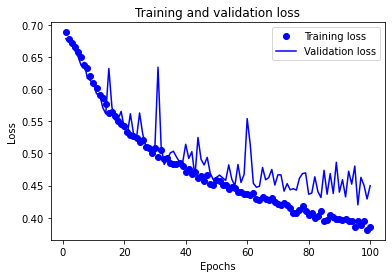

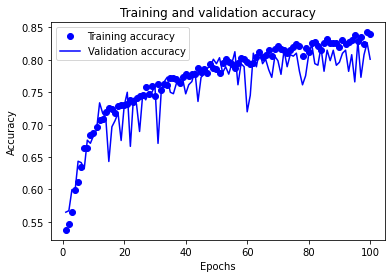

6/6 [==============================] - 0s 2ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		134 			93
Actually Negative		17 			188

Acc 0.7453703703703703
f1 0.708994708994709
f2 0.6326723323890463
MCC 0.5313526960215621

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		39 			64
Actually Negative		10 			69

Acc 0.5934065934065934
f1 0.513157894736842
f2 0.42299349240780915
MCC 0.2816499262638357


In [22]:
complete_experiment('CBERS_321', '2m', '64_48')

## Experimentos - CBERS_432

Fold 0: Train Loss 0.435 | Train Acc 0.800
Fold 0: Val   Loss 0.535 | Val   Acc 0.759
Fold 1: Train Loss 0.439 | Train Acc 0.774
Fold 1: Val   Loss 0.500 | Val   Acc 0.805
Fold 2: Train Loss 0.442 | Train Acc 0.780
Fold 2: Val   Loss 0.453 | Val   Acc 0.791
Fold 3: Train Loss 0.378 | Train Acc 0.827
Fold 3: Val   Loss 0.457 | Val   Acc 0.744
Fold 4: Train Loss 0.415 | Train Acc 0.801
Fold 4: Val   Loss 0.453 | Val   Acc 0.826


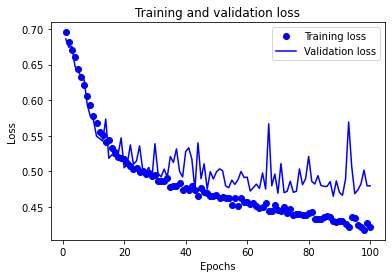

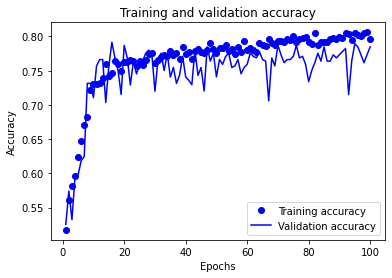

6/6 [==============================] - 0s 2ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		245 			0
Actually Negative		187 			0

Acc 0.5671296296296297
f1 0.723781388478582
f2 0.8675637393767706
MCC 0.0

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		107 			0
Actually Negative		75 			0

Acc 0.5879120879120879
f1 0.7404844290657439
f2 0.8770491803278689
MCC 0.0


In [23]:
complete_experiment('CBERS_432', '2m', '64_48')

## Experimentos - Google 2m

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 rescaling_35 (Rescaling)    (None, 30, 30, 3)         0         
                                                                 
 conv2d_105 (Conv2D)         (None, 28, 28, 2)         56        
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 14, 14, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 12, 12, 4)         76        
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 6, 6, 4)          0         
 g2D)                                                     

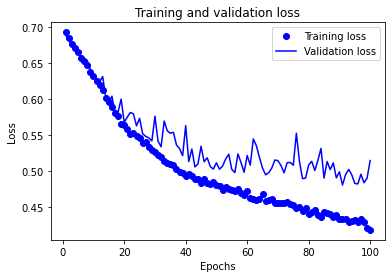

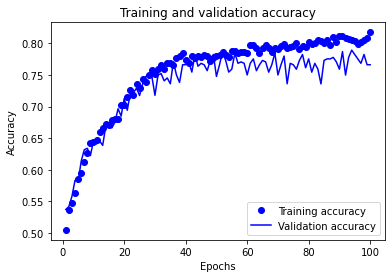

6/6 [==============================] - 0s 2ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		212 			26
Actually Negative		51 			143

Acc 0.8217592592592593
f1 0.846307385229541
f2 0.8724279835390946
MCC 0.6399376252005732

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		95 			17
Actually Negative		40 			30

Acc 0.6868131868131868
f1 0.7692307692307693
f2 0.8147512864493998
MCC 0.30767052265729705


In [32]:
complete_experiment('Google', '2m', '64_48')

## Experimentos - Google 0,5m

Fold 0: Train Loss 0.036 | Train Acc 0.994
Fold 0: Val   Loss 0.856 | Val   Acc 0.804
Fold 1: Train Loss 0.051 | Train Acc 0.994
Fold 1: Val   Loss 0.918 | Val   Acc 0.828
Fold 2: Train Loss 0.034 | Train Acc 0.995
Fold 2: Val   Loss 1.001 | Val   Acc 0.800
Fold 3: Train Loss 0.072 | Train Acc 0.993
Fold 3: Val   Loss 1.418 | Val   Acc 0.723
Fold 4: Train Loss 0.057 | Train Acc 0.989
Fold 4: Val   Loss 1.238 | Val   Acc 0.831


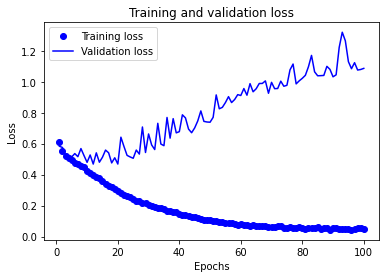

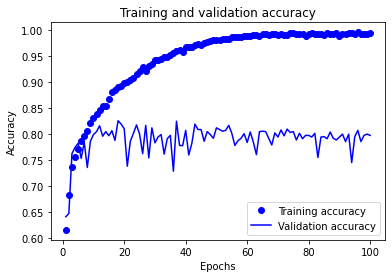

12/12 [==============================] - 0s 18ms/step

#-----------------------------< Training >-----------------------------#
n = 1248			Predicted Positive 	Predicted Negative
Actually Positive		770 			3
Actually Negative		0 			475

Acc 0.9975961538461539
f1 0.9980557355800389
f2 0.9968928016571724
MCC 0.9949207123308946

#-----------------------------< Test >-----------------------------#
n = 382			Predicted Positive 	Predicted Negative
Actually Positive		152 			105
Actually Negative		35 			90

Acc 0.6335078534031413
f1 0.6846846846846847
f2 0.6255144032921811
MCC 0.2923192500722272


In [25]:
complete_experiment('Google', '05m', '64_48')